In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import os
from PIL import Image

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"renessamat","key":"5ee514a8172fc77d46de3d5452a1b49a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub

path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


In [ ]:
def load_dataset(base_path):
    X = []
    y = []
    class_names = sorted(os.listdir(base_path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(base_path, class_name)
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            try:
                img = Image.open(img_path).convert('L')
                img = img.resize((48, 48))
                img_array = np.array(img, dtype='float32') / 255.0
                X.append(img_array.flatten())
                y.append(label_map[class_name])
            except Exception as e:
                print("Hata:", e, "Dosya:", img_path)

    return np.array(X), np.array(y), label_map

In [ ]:
train_path = "/kaggle/input/fer2013/train"
test_path = "/kaggle/input/fer2013/test"

X_train, y_train, label_map = load_dataset(train_path)
X_test, y_test, _ = load_dataset(test_path)

In [ ]:
print("Etiketler:", label_map)
print("Eğitim örnek sayısı:", X_train.shape[0])
print("Test örnek sayısı:", X_test.shape[0])

Etiketler: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Eğitim örnek sayısı: 28709
Test örnek sayısı: 7178


In [ ]:
def apply_pca(X, num_components=2):
    X_meaned = X - np.mean(X, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    sorted_idx = np.argsort(eigen_values)[::-1]

    eigen_vectors = eigen_vectors[:, sorted_idx]
    eigen_vectors = eigen_vectors[:, :num_components]

    X_reduced = np.dot(X_meaned, eigen_vectors)
    return X_reduced, eigen_vectors, np.mean(X, axis=0)


In [ ]:

X_train_pca, pca_projection_matrix, X_train_mean = apply_pca(X_train, num_components=150)

X_test_centered = X_test - X_train_mean
X_test_pca = np.dot(X_test_centered, pca_projection_matrix)

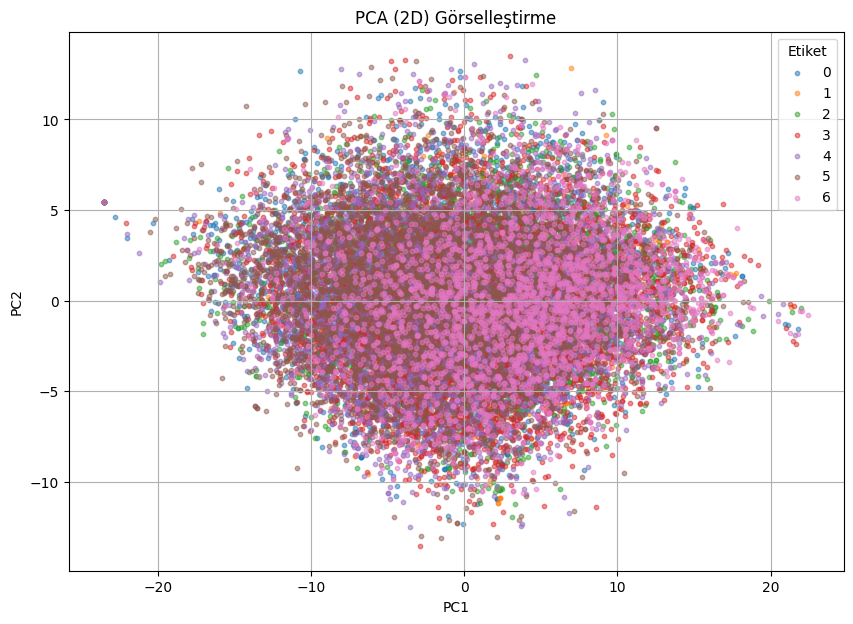

In [ ]:
plt.figure(figsize=(10, 7))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=label, alpha=0.5, s=10)
plt.legend(title="Etiket")
plt.title("PCA (2D) Görselleştirme")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

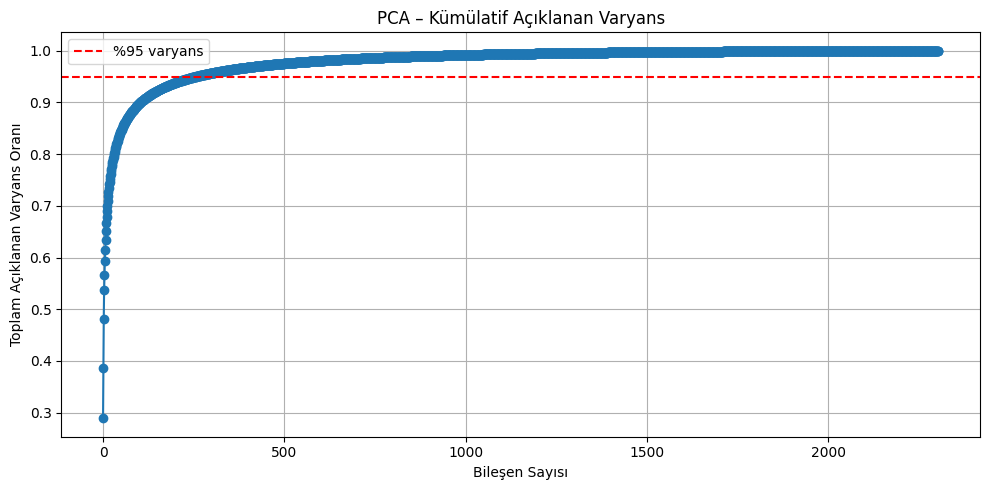

👉 %95 varyansı açıklamak için gereken bileşen sayısı: 257


In [ ]:
def explained_variance_plot(X):
    X_meaned = X - np.mean(X, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    eigen_vals, _ = np.linalg.eigh(cov_mat)

    sorted_eigen_vals = np.sort(eigen_vals)[::-1]

    total = np.sum(sorted_eigen_vals)
    explained_variance_ratio = sorted_eigen_vals / total
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_variance, marker='o')
    plt.axhline(y=0.95, color='r', linestyle='--', label='%95 varyans')
    plt.title("PCA – Kümülatif Açıklanan Varyans")
    plt.xlabel("Bileşen Sayısı")
    plt.ylabel("Toplam Açıklanan Varyans Oranı")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"%95 varyansı açıklamak için gereken bileşen sayısı: {num_components_95}")

explained_variance_plot(X_train)


In [ ]:
def apply_lda(X, y, num_components=2):
    class_labels = np.unique(y)
    n_features = X.shape[1]

    mean_overall = np.mean(X, axis=0)
    Sw = np.zeros((n_features, n_features))
    Sb = np.zeros((n_features, n_features))

    for c in class_labels:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)

        Sw += np.dot((X_c - mean_c).T, (X_c - mean_c))

        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
        Sb += n_c * np.dot(mean_diff, mean_diff.T)

    eig_vals, eig_vecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))

    sorted_indices = np.argsort(np.abs(eig_vals))[::-1]
    eig_vecs = eig_vecs[:, sorted_indices]

    W = eig_vecs[:, :num_components]

    X_lda = np.dot(X, W.real)
    return X_lda, W.real

In [ ]:
X_train_lda, lda_projection_matrix = apply_lda(X_train, y_train, num_components=6)
X_test_lda = np.dot(X_test, lda_projection_matrix)

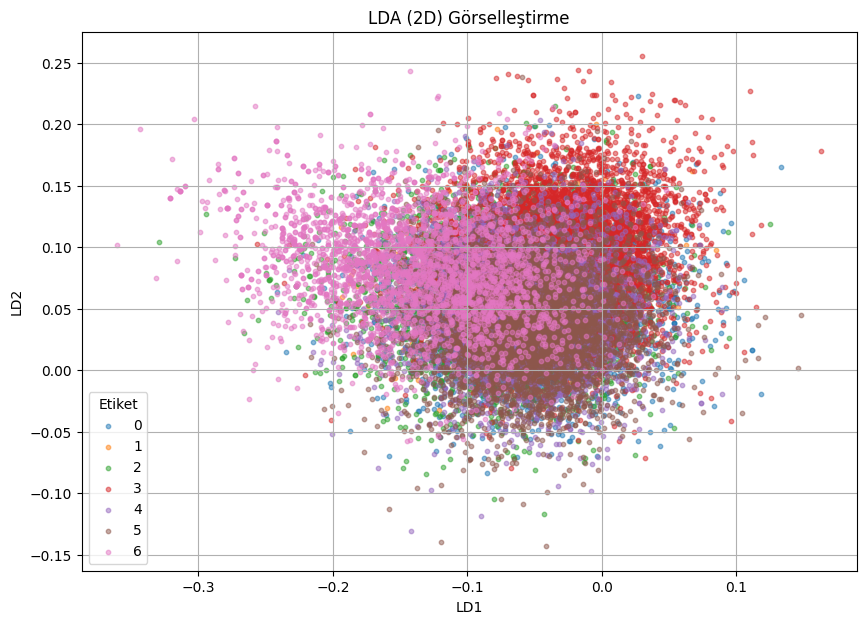

In [ ]:
plt.figure(figsize=(10, 7))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_train_lda[idx, 0], X_train_lda[idx, 1], label=label, alpha=0.5, s=10)
plt.legend(title="Etiket")
plt.title("LDA (2D) Görselleştirme")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lda = LogisticRegression(max_iter=1000)
clf_pca = LogisticRegression(max_iter=1000)
clf_lda.fit(X_train_lda, y_train)
clf_pca.fit(X_train_pca, y_train)
y_pred_lda = clf_lda.predict(X_test_lda)
y_pred_pca = clf_pca.predict(X_test_pca)

Doğruluk Oranı: 0.3457787684591808


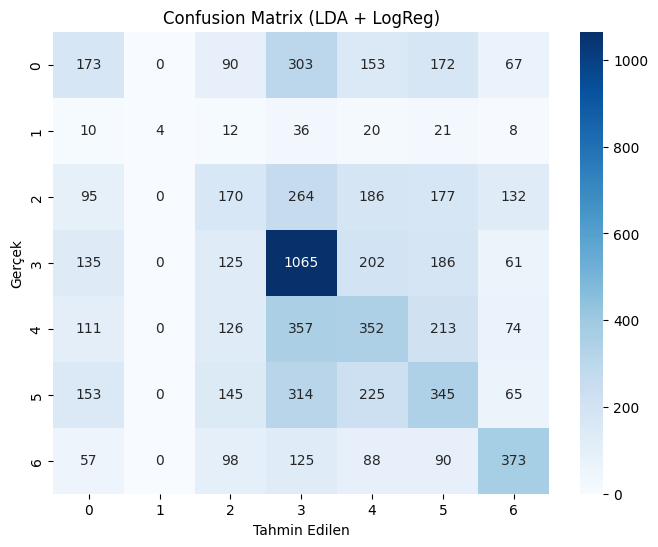

In [ ]:
print("Doğruluk Oranı:", accuracy_score(y_test, y_pred_lda))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_lda), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LDA + LogReg)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

Doğruluk Oranı: 0.3779604346614656


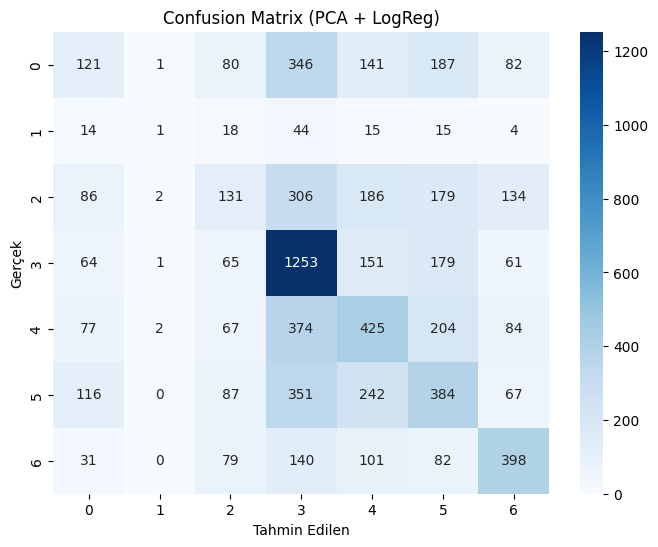

In [ ]:
print("Doğruluk Oranı:", accuracy_score(y_test, y_pred_pca))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PCA + LogReg)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()

PCA + k-NN Doğruluk Oranı: 0.34633602674839786


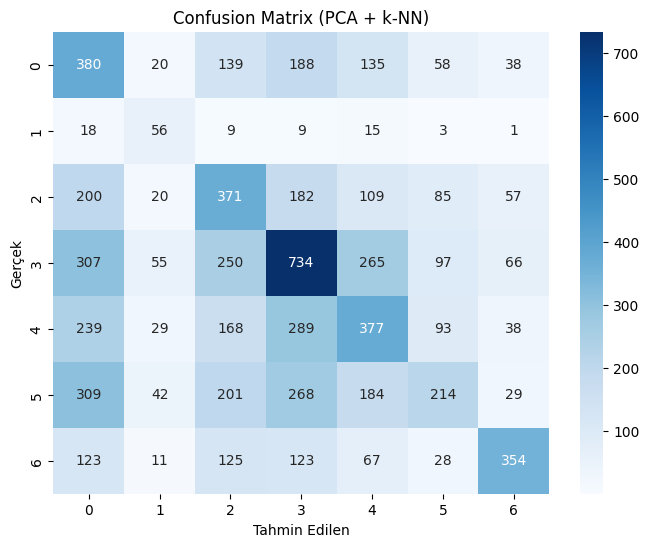

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_pca, y_train)

y_pred_knn = knn_clf.predict(X_test_pca)

print("PCA + k-NN Doğruluk Oranı:", accuracy_score(y_test, y_pred_knn))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PCA + k-NN)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()


PCA + Random Forest Doğruluk Oranı: 0.42407355809417663


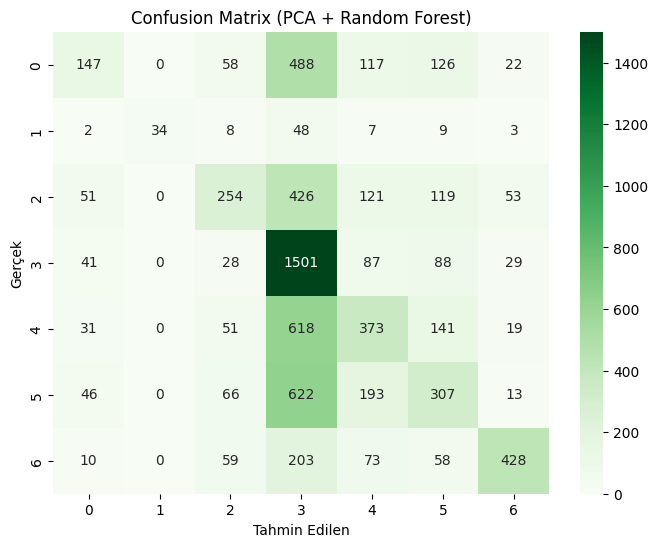

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pca, y_train)

y_pred_rf = rf_clf.predict(X_test_pca)

print("PCA + Random Forest Doğruluk Oranı:", accuracy_score(y_test, y_pred_rf))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (PCA + Random Forest)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()


LDA + Random Forest doğruluk oranı: 0.3715519643354695


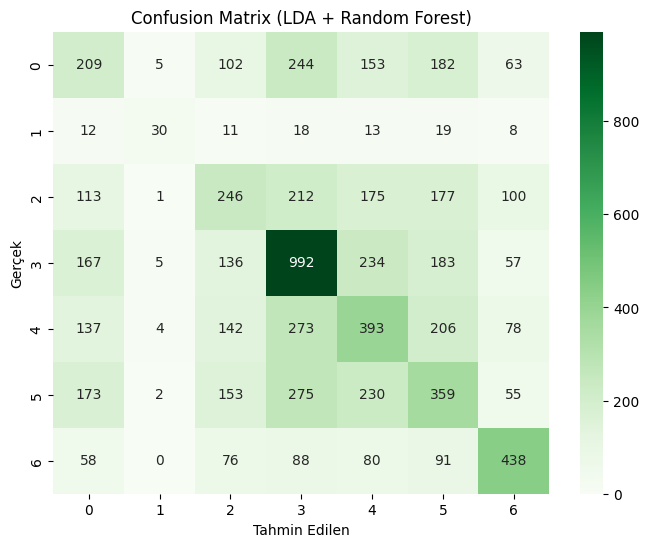

In [ ]:
rf_lda = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lda.fit(X_train_lda, y_train)

y_pred_lda_rf = rf_lda.predict(X_test_lda)

print("LDA + Random Forest doğruluk oranı:", accuracy_score(y_test, y_pred_lda_rf))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_lda_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix (LDA + Random Forest)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.show()
